In [1]:
# Import Libraries
import pandas as pd 
import re 
from quality_control import filter_low_counts 
from Normalize import normalize_rnaseq_data 
from Visualize import visualize  
from differential_analysis import run_differential_analysis
from GSEA import run_gsea_analysis, save_stream_to_file 

In [2]:
# Read Input File
df = pd.read_csv('GSE99611_read_count.csv', sep = ',', dtype={0: str})
df = df.dropna()
print(df.shape)
df.head()

(33296, 25)


,ID_REF,GSM2648567,GSM2648568,GSM2648569,GSM2648570,GSM2648571,GSM2648572,GSM2648573,GSM2648574,GSM2648575,...,GSM2648581,GSM2648582,GSM2648583,GSM2648584,GSM2648585,GSM2648586,GSM2648587,GSM2648588,GSM2648589,GSM2648590
0,7892501,5.406718,5.519148,4.177698,5.569887,5.994274,5.534124,6.119857,3.727363,4.819328,...,6.068605,6.656123,5.566483,5.819843,5.713768,5.684574,5.600919,5.465386,6.048588,6.390351
1,7892502,4.116842,4.836938,4.225375,4.411821,4.717926,4.296736,4.744492,3.760642,4.254225,...,4.368755,4.012615,4.304502,4.443436,4.181638,4.085864,4.288531,4.543927,3.960131,4.024352
2,7892503,2.661841,3.617933,3.426892,2.756292,2.937344,4.229037,2.938271,3.146627,3.350369,...,3.014488,2.629324,3.429700,3.151407,5.045113,2.928856,3.169045,3.572539,2.538804,3.159325
3,7892504,8.254515,8.158819,7.845526,7.948907,8.013678,7.873485,8.222703,8.081101,7.392011,...,7.943646,7.757128,7.977602,7.733406,8.323465,8.015525,7.786586,7.679242,8.059721,8.101820
4,7892505,2.268258,2.327442,2.252517,2.247316,2.778638,2.341493,2.660242,2.391670,2.784248,...,2.567652,2.229839,2.990818,2.347733,2.711807,2.756714,2.688166,2.392972,2.516069,2.336014


In [3]:
#### convert ID_REF to gene name ####
id2name = pd.read_csv('id_to_name.csv', sep=',', encoding='latin-1')
first_column = id2name.iloc[:, 0]
last_column = id2name.iloc[:, -3]
id2name = dict()
for ii, (gene_id, gene_line) in enumerate(zip(first_column, last_column)):
    try:
        idx1 = gene_line.index('(')
        idx2 = gene_line.index(')')
    except:
        continue 
    gene_name = gene_line[idx1+1:idx2]
    if any(char.islower() for char in gene_name) or len(gene_name) > 7 or ' ' in gene_name or ',' in gene_name\
        or '/' in gene_name or '-' in gene_name or "'" in gene_name: 
        continue 
    print(gene_id, gene_name)
    id2name[str(gene_id)] = gene_name
    if ii > 10000: 
        break 
df['gene_name'] = df['ID_REF'].map(id2name)
df = df.dropna(subset=['gene_name'])

7896740 OR4F17
7896744 OR4F16
7896761 SAMD11
7896798 PLEKHN1
7896817 ISG15
7896822 AGRN
7896859 MIR200B
7896861 MIR200A
7896863 MIR429
7896865 TTLL10
7896878 B3GALT6
7896882 SCNN1D
7896908 PUSL1
7896917 GLTPD1
7896921 TAS1R3
7896929 VWA1
7896937 ATAD3C
7896952 ATAD3A
7896961 ATAD3B
7897006 MMP23B
7897026 CALML6
7897034 GABA
7897044 PRKCZ
7897089 PLCH2
7897128 ACTRT2
7897132 PRDM16
7897154 GEF
7897172 TPRG1L
7897179 TP73
7897196 CCDC27
7897227 AJAP1
7897236 KCNAB2
7897257 RNF207
7897263 RNF207
7897286 UNQ6193
7897288 ESPN
7897295 TAS1R1
7897305 ZBTB48
7897322 PHF13
7897329 THAP3
7897339 CAMTA1
7897416 SLC45A1
7897426 CA6
7897449 SPSB1
7897469 TMEM201
7897482 PIK3CD
7897509 NMNAT1
7897522 RBP7
7897561 KIF1B
7897620 PGD
7897632 APITD1
7897648 PEX14
7897663 TARDBP
7897675 ANGPTL7
7897685 UBIAD1
7897691 PTCHD2
7897714 FBXO44
7897728 FBXO6
7897745 AGTRAP
7897774 CLCN6
7897801 RNU5E
7897803 PLOD1
7897824 MFN2
7897849 MIIP
7897860 TNFRSF8
7897955 AADACL4
7897960 AADACL3
7897978 PRAMEF1
7897987

In [4]:
gene_name_list = df['gene_name'].tolist()
print(len(gene_name_list))
df = df.drop('ID_REF', axis=1)
df = df.set_index('gene_name')
print(df.shape)
df.head()

5508
(5508, 24)


,GSM2648567,GSM2648568,GSM2648569,GSM2648570,GSM2648571,GSM2648572,GSM2648573,GSM2648574,GSM2648575,GSM2648576,...,GSM2648581,GSM2648582,GSM2648583,GSM2648584,GSM2648585,GSM2648586,GSM2648587,GSM2648588,GSM2648589,GSM2648590
gene_name,,,,,,,,,,,,,,,,,,,,,
OR4F17,2.797155,2.923030,2.681677,2.792392,2.848559,2.769326,2.865936,2.878839,2.928945,2.998397,...,2.819964,2.947936,2.820742,2.910570,2.906625,2.814629,2.696859,2.772464,2.725716,2.704007
OR4F16,3.996211,4.076768,4.228961,3.968000,4.122972,3.917877,4.080551,4.202340,3.962312,4.149804,...,4.193371,4.067175,4.302435,4.361854,4.140924,4.100578,4.109092,4.387219,4.258374,4.083158
SAMD11,6.145244,6.023035,6.193437,6.198841,5.790114,6.193780,6.233316,6.554033,6.447859,6.223758,...,5.940135,6.117937,6.345879,6.313631,6.176176,6.379351,6.143690,6.371743,6.108640,6.042447
PLEKHN1,5.960125,6.246845,6.037925,6.124233,6.015615,6.182974,6.106166,6.336078,6.159523,6.403386,...,6.141335,5.889953,6.071280,6.255396,6.079775,6.209034,6.116946,6.054492,6.048872,6.022977
ISG15,5.856219,5.725297,5.966060,6.009751,5.841102,5.753067,5.874535,5.956901,6.216661,9.739830,...,5.881778,5.928771,5.862872,8.813557,5.858665,6.027842,5.801332,5.649072,5.562079,5.757367


In [5]:
df.to_csv("read_counts.csv")

In [6]:
# 1. Qaulity Control
df_filtered = filter_low_counts(df)
print(df_filtered.shape)
df_filtered.head()

(674, 24)


,GSM2648567,GSM2648568,GSM2648569,GSM2648570,GSM2648571,GSM2648572,GSM2648573,GSM2648574,GSM2648575,GSM2648576,...,GSM2648581,GSM2648582,GSM2648583,GSM2648584,GSM2648585,GSM2648586,GSM2648587,GSM2648588,GSM2648589,GSM2648590
gene_name,,,,,,,,,,,,,,,,,,,,,
KCNAB2,11.77360,11.65811,11.78295,11.76168,11.49308,11.66682,11.75274,11.73526,11.91517,10.808950,...,11.87151,11.88268,11.91827,11.109640,11.88023,11.80213,11.68534,11.84706,11.851680,11.84316
PGD,12.09138,12.19308,12.09456,12.18317,12.22029,12.20440,12.08412,12.14114,12.29359,12.341250,...,12.34302,12.34407,12.19785,12.305170,12.30362,12.13529,12.29014,12.25790,12.289110,12.35299
RNU5E,10.44567,10.49438,10.48125,10.47975,10.29784,10.59162,10.67692,10.64875,10.45195,10.283550,...,10.77708,10.90655,10.17268,10.027240,10.56677,10.22750,9.93444,10.13320,9.824701,10.60767
PLOD1,10.68864,10.57311,10.68622,10.64175,10.52194,10.55255,10.75768,10.69255,10.20540,9.583244,...,10.09721,10.24924,10.36289,9.730327,10.32237,10.28830,10.17208,10.35784,10.363240,10.28597
MFN2,10.33641,10.17336,10.31723,10.30395,10.28382,10.22802,10.27665,10.33299,10.38821,10.074600,...,10.27498,10.29732,10.36629,10.077220,10.31382,10.31037,10.36901,10.35193,10.303500,10.26558


In [7]:
### 1.5 randomly generating case_samples control_samples 
with open('GSE99611_sample_label.csv', 'r') as fin:
    lines = fin.readlines() 
labels = [int(line.strip().split(',')[1]) for line in lines]

patient_names = df.columns.tolist()

case_samples = [patient for patient,label in zip(patient_names, labels) if label==1]
control_samples = [patient for patient,label in zip(patient_names, labels) if label==0]
print(case_samples)
print(control_samples)

['GSM2648568', 'GSM2648569', 'GSM2648573', 'GSM2648575', 'GSM2648576', 'GSM2648580', 'GSM2648583', 'GSM2648585', 'GSM2648587', 'GSM2648590']
['GSM2648567', 'GSM2648570', 'GSM2648571', 'GSM2648572', 'GSM2648574', 'GSM2648577', 'GSM2648578', 'GSM2648579', 'GSM2648581', 'GSM2648582', 'GSM2648584', 'GSM2648586', 'GSM2648588', 'GSM2648589']


In [8]:
pd.DataFrame(case_samples).to_csv("case_label.txt",  header=None, index=None, sep=' ')
pd.DataFrame(control_samples).to_csv("control_label.txt",  header=None, index=None, sep=' ')

In [9]:
# 2. Normalize   
df_normalized, case_df_cpm, control_df_cpm = normalize_rnaseq_data(df_filtered, case_samples, control_samples)
print('normalize', df_normalized.shape)
print(case_df_cpm.shape, case_df_cpm.head())
print(control_df_cpm.shape, control_df_cpm.head())

normalize (674, 24)
(674, 10)             GSM2648568   GSM2648569   GSM2648573   GSM2648575   GSM2648576  \
gene_name                                                                    
KCNAB2     1595.942209  1615.302380  1609.201778  1633.635175  1490.283648   
PGD        1669.177168  1658.020407  1654.574796  1685.518633  1701.549464   
RNU5E      1436.632868  1436.854783  1461.898982  1433.019686  1417.844139   
PLOD1      1447.410647  1464.953734  1472.956756  1399.216328  1321.289471   
MFN2       1392.686691  1414.369591  1407.093448  1424.280582  1389.035165   

            GSM2648580   GSM2648583   GSM2648585   GSM2648587   GSM2648590  
gene_name                                                                   
KCNAB2     1615.408740  1636.424516  1626.223396  1598.214174  1620.823875  
PGD        1682.926220  1674.811930  1684.179069  1680.933199  1690.597874  
RNU5E      1431.135678  1396.748265  1446.430632  1358.742049  1451.737948  
PLOD1      1387.297989  1422.864833  1

(1348, 24)


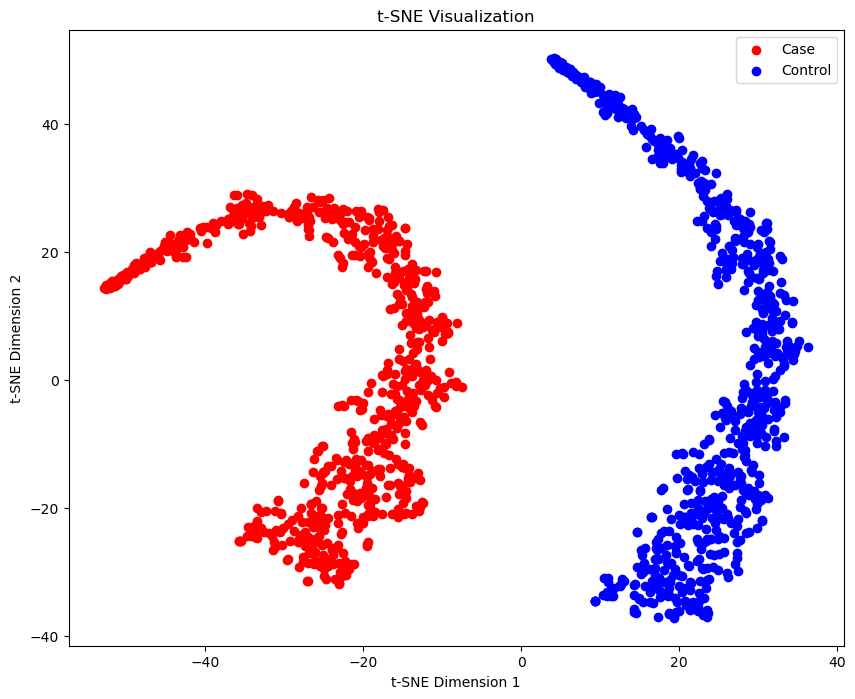

In [10]:
### 3. visualize 
stream = visualize(case_df_cpm, control_df_cpm)

In [11]:
### 4. differential analysis 
genename_list_short = [str(x).strip() for x in case_df_cpm.index]
print(len(genename_list_short), genename_list_short)

significant_genes, significant_cases, significant_controls = \
        run_differential_analysis(genename_list_short, case_df_cpm, control_df_cpm) 

674 ['KCNAB2', 'PGD', 'RNU5E', 'PLOD1', 'MFN2', 'EFHD2', 'NECAP2', 'RPL11', 'PNRC2', 'SRRM1', 'CLIC4', 'TMEM50A', 'SDHD', 'SEPN1', 'CD52', 'HMGN2', 'RPS6KA1', 'CCDC72', 'STX12', 'PHACTR4', 'EIF3I', 'HDAC1', 'RBBP4', 'ZMYM4', 'EIF2C1', 'RPS27', 'MFSD2A', 'RLF', 'SMAP2', 'ZNF642', 'NFYC', 'CTPS', 'PPCS', 'YBX1', 'K', 'ATP6V0B', 'RPS8', 'SNORD46', 'TMEM69', 'OSBPL9', 'BTF3L4', 'GPX7', 'MRPL37', 'SRSF11', 'ACADM', 'RPL17', 'LPHN2', 'SH3GLB1', 'HIAT1', 'RTCD1', 'RPL17', 'SARS', 'GSTM4', 'GSTM1', 'AHCYL1', 'CD53', 'CEPT1', 'RAP1A', 'HIPK1', 'ATP1A1', 'PHGDH', 'SRGAP2', 'NBPF10', 'NBPF16', 'TXNIP', 'PEX11B', 'NBPF11', 'PDIA3P', 'VOPP1', 'NBPF15', 'NBPF16', 'PLEKHO1', 'MRPS21', 'RPRD2', 'ECM1', 'SCNM1', 'INTS3', 'RPS27', 'UBAP2L', 'HAX1', 'IL6R', 'LMNA', 'APOA1BP', 'IFI16', 'SLAMF8', 'PEA15', 'NCSTN', 'UFC1', 'FCER1G', 'CD32', 'ATF6', 'UHM', 'MGST3', 'POGK', 'SFT2D2', 'ATP1B1', 'BAT2L2', 'PRDX6', 'RASAL2', 'CEP350', 'QSOX1', 'XPR1', 'MR1', 'RPS27A', 'PTPRC', 'IPO9', 'BTG2', 'SRGAP2', 'IKBKE', 

In [18]:
### 6. GSEA 
stream = run_gsea_analysis(significant_genes[0].tolist(), 'pathway_with_pvalues.csv')

In [19]:
stream

(<_io.BytesIO at 0x24a894ad210>,
                                     Pathway   P-value
 0                                  Ribosome  0.000185
 1                       Coronavirus disease  0.000399
 2  Vasopressin-regulated water reabsorption  0.006586
 3                      Salmonella infection  0.036889)

In [ ]:
# Congratulations! Completed